In [11]:
import sys
import os
root_dir = '/home/qing/Desktop/Closed-Loop-Learning/HINT/'
os.chdir(root_dir)
from train import *
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
sys.argv = []
args = parse_args()
args.resume = './models/image.TRAN.relative_universal/model_100000.p'
args.input = 'image'
args.model = 'TRAN.relative_universal'
args.nhead = 8
args.enc_layers = 6
args.dec_layers = 1
args.hid_dim = 512
args.max_rel_pos = 15
args

Namespace(batch_size=128, cos_sim_margin=0.2, curriculum='no', dec_layers=1, dropout=0.5, early_stop=None, emb_dim=128, enc_layers=6, epochs=10, epochs_eval=1, fewshot=None, grad_clip=5.0, hid_dim=512, input='image', iterations=None, iterations_eval=None, layers=1, lr=0.001, lr_scheduler='constant', main_dataset_ratio=0, max_op_train=None, max_rel_pos=15, model='TRAN.relative_universal', nhead=8, output_dir='outputs/', perception_pretrain='data/perception_pretrain/model.pth.tar_78.2_match', pos_emb_type='sin', result_encoding='decimal', resume='./models/image.TRAN.relative_universal/model_100000.p', save_model=False, seed=0, train_size=None, wandb='HINT', warmup_steps=100)

In [3]:
train_set = HINT('train', input=args.input, fewshot=args.fewshot, 
                    n_sample=args.train_size, max_op=args.max_op_train,
                    main_dataset_ratio=args.main_dataset_ratio)
val_set = HINT('val', input=args.input, fewshot=args.fewshot)
test_set = HINT('test', input=args.input, fewshot=args.fewshot)
print('train:', len(train_set), 'val:', len(val_set), 'test:', len(test_set))

args.train_set = train_set
args.val_set = val_set
args.test_set = test_set

train: 998000 val: 4698 test: 46620


In [4]:
args.res_enc = ResultEncoding(args.result_encoding)
model = make_model(args)
if args.resume:
    print('Load checkpoint from ' + args.resume)
    ckpt = torch.load(args.resume)
    model.load_state_dict(ckpt['model_state_dict'])
model.to(DEVICE)

n_params = sum(p.numel() for p in model.parameters())
print('Num params:', n_params)

Load checkpoint from ./models/image.TRAN.relative_universal/model_100000.p
Num params: 19261645


In [6]:
dataset = test_set
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64,
                        shuffle=False, num_workers=4, collate_fn=HINT_collate)

model.eval()

with torch.no_grad():
    src_emb_list = []
    symbol_list = []
    img_path_list = []
    for sample in tqdm(dataloader):
        if args.input == 'image':
            src = sample['img_seq']
        elif args.input == 'symbol':
            src = torch.tensor([x for s in sample['sentence'] for x in s])
        src_len = sample['len']
        src = src.to(DEVICE)
        src_emb = model.embedding_in.image_encoder(src).detach().cpu().numpy()
        src_emb_list.append(src_emb)
        symbols = [x for s in sample['expr'] for x in s]
        symbol_list.append(symbols)
        img_paths = [x for s in sample['img_paths'] for x in s]
        img_path_list.append(img_paths)
    src_embs = np.concatenate(src_emb_list, axis=0)
    symbols = np.array([y for x in symbol_list for y in x])
    img_paths = [y for x in img_path_list for y in x]

100%|█████████████████████████████████████████| 729/729 [00:45<00:00, 16.01it/s]


In [7]:
path2emb = {}
for s, p, e in zip(symbols, img_paths, src_embs):
    if p in path2emb:
        continue
    path2emb[p] = (s, e)

sym2emb = {}
for s, e in path2emb.values():
    if s not in sym2emb:
        sym2emb[s] = []
    sym2emb[s].append(e)

for s, e in sym2emb.items():
    print(s, len(e))

7 152
1 1266
0 363
6 163
4 329
3 495
9 149
2 1243
5 202
8 147
* 120
/ 33
- 1205
+ 1089
( 798
) 797


In [8]:
symbols_nondep = []
src_embs_nondep = []
n_points_per_class = 10000
for s, e in sym2emb.items():
    e = random.sample(e, k=min(n_points_per_class, len(e)))
    symbols_nondep.extend([s] * len(e))
    src_embs_nondep.extend(e)
symbols_nondep = np.array(symbols_nondep)
src_embs_nondep = np.stack(src_embs_nondep)

print(len(symbols_nondep), src_embs_nondep.shape)

8551 (8551, 128)


In [9]:
from sklearn import manifold

S_points = src_embs_nondep
S_color = symbols_nondep

t_sne = manifold.TSNE(
    n_components=2,
    learning_rate="auto",
    perplexity=30,
    n_iter=250,
    init="pca"
)
S_t_sne = t_sne.fit_transform(S_points)

/home/qing/.virtualenvs/hint/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


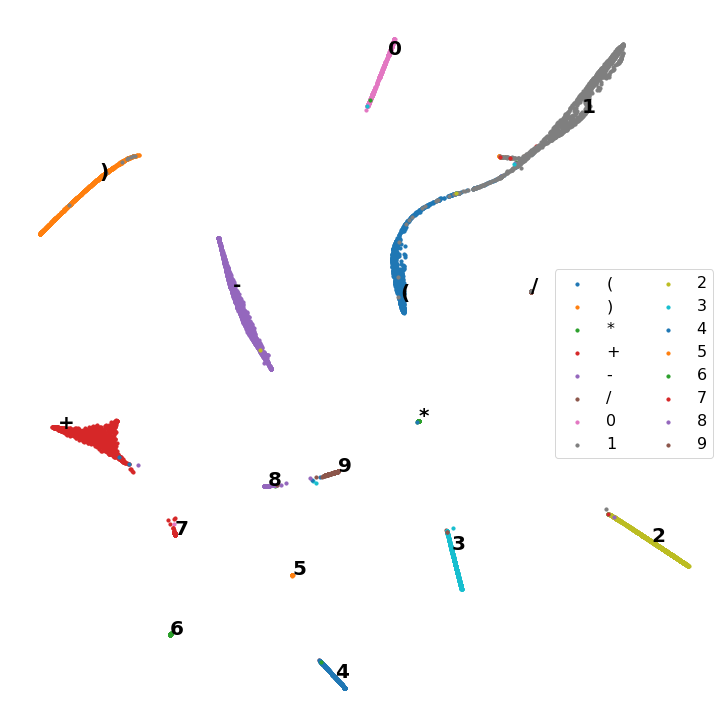

In [14]:
plt.rcParams['font.size'] = '16'
def plot_2d(points, labels, title):
    fig, ax = plt.subplots(figsize=(10, 10), facecolor="white", constrained_layout=True)
    add_2d_scatter(ax, points, labels)


def add_2d_scatter(ax, points, labels):
    x, y = points.T
    for c in np.unique(labels):
        ix = np.where(labels == c)
        ax.scatter(x[ix], y[ix], label=c, s=10, alpha=1)
    
    shown = []
    for i, c in enumerate(labels):
        if c in shown: continue
        ax.annotate(c, (x[i], y[i]), size=20, weight='bold')
        shown.append(c)
        

plot_2d(S_t_sne, S_color, "T-distributed Stochastic  \n Neighbor Embedding")
plt.legend(ncol=2)
plt.axis('off')
plt.savefig('results/figures/img_tSNE.png', dpi=300, bbox_inches='tight')
plt.show()